<a href="https://colab.research.google.com/github/amay1212/Grokking-DL/blob/main/network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'assignments/assignment1/'
assert FOLDERNAME is not None, "assignments/assignment1/"

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/assignments/assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [37]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [4]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

#print(x.shape, w.shape, b.shape)
out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])
print(out)
# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

[[1.49834967 1.70660132 1.91485297]
 [3.25553199 3.5141327  3.77273342]]
Testing affine_forward function:
difference:  9.769849468192957e-10


In [5]:
round(9.769849468192957e-10, 5)

0.0

# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [6]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
#print(dx_num)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print(dx_num.shape)
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

(10, 2, 3) (6, 5) (5,)
======> (10, 5) (6, 5) (10, 2, 3)
printing dw shape (6, 5)
Testing affine_backward function:
(10, 2, 3)
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [7]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

[[0.         0.         0.         0.        ]
 [0.         0.         0.04545455 0.13636364]
 [0.22727273 0.31818182 0.40909091 0.5       ]]
Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [8]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

[[0.41795341 1.39710028 0.         0.         0.         0.
  0.         1.86172902 0.         0.        ]
 [0.         0.29490764 0.         0.95218767 1.32931659 0.52465245
  0.         0.88953195 0.12444653 0.99109251]
 [0.03514666 0.26207083 0.14320173 0.90101716 0.23185863 0.
  0.12001014 0.         0.26917456 0.333667  ]
 [0.27423503 0.76215717 0.         0.29214712 0.         0.1228747
  0.         0.70286283 0.         0.        ]
 [0.         0.         0.         0.56834936 0.         1.27286625
  1.27292534 1.58102968 0.         0.9217743 ]
 [0.         0.         0.47021125 0.03196734 0.04448574 0.47824879
  0.         0.         0.         0.        ]
 [0.         0.49258765 0.83736166 0.         0.         0.
  0.         0.         0.44148975 0.16411113]
 [0.         0.         0.         0.         0.26338593 0.1672181
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.36343905 0.94992777 0.
  0.27031704 0.         0.         0.65576139]

In [9]:
round(3.2756349136310288e-12, 5)

[[0.41794341 1.39710028 0.         0.         0.         0.
  0.         1.86172902 0.         0.        ]
 [0.         0.29490764 0.         0.95218767 1.32931659 0.52465245
  0.         0.88953195 0.12444653 0.99109251]
 [0.03514666 0.26207083 0.14320173 0.90101716 0.23185863 0.
  0.12001014 0.         0.26917456 0.333667  ]
 [0.27423503 0.76215717 0.         0.29214712 0.         0.1228747
  0.         0.70286283 0.         0.        ]
 [0.         0.         0.         0.56834936 0.         1.27286625
  1.27292534 1.58102968 0.         0.9217743 ]
 [0.         0.         0.47021125 0.03196734 0.04448574 0.47824879
  0.         0.         0.         0.        ]
 [0.         0.49258765 0.83736166 0.         0.         0.
  0.         0.         0.44148975 0.16411113]
 [0.         0.         0.         0.         0.26338593 0.1672181
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.36343905 0.94992777 0.
  0.27031704 0.         0.         0.65576139]

0.0

## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
1. Sigmoid - For sigmoid activation function(1/(1+e^-x), for larger gradients, this could have a value close to 1,and for very very smaller values or gradients, this can get to 0.

2. ReLU - In RELU, negative coefficients are made 0 during forward prop, whereas in back prop the positive values get to 1, making all the negative values 0.

3. Leaky ReLU - Works for gradients when lesser than 0, it provides a small value in the slight formula modification

  Relu formula = max(0, x)

  Leaky Relu formula - max(0.01x, x)

  f'(x) = 1 if x > 0
  f'(x) = 0.01 if x <= 0


  As we can see during back prop, for values smaller than 0, the f'x is not 0'd out.

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [10]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

[[0.         0.         0.         0.         0.82833835 0.
  0.23055046 2.78486972 0.         0.19643551]
 [0.         2.44273488 0.74470594 0.         0.         0.
  0.         0.         0.71375296 0.        ]]
(2, 10) (2, 10)
(2, 3, 4) (12, 10) (10,)
======> (2, 10) (12, 10) (2, 3, 4)
printing dw shape (12, 10)
[[0.         0.         0.         0.         0.82834104 0.
  0.2305532  2.78487734 0.         0.19643843]
 [0.         2.44273488 0.74470594 0.         0.         0.
  0.         0.         0.71375296 0.        ]]
[[0.         0.         0.         0.         0.82833566 0.
  0.23054772 2.7848621  0.         0.19643259]
 [0.         2.44273488 0.74470594 0.         0.         0.
  0.         0.         0.71375296 0.        ]]
[[0.         0.         0.         0.         0.82832977 0.
  0.23053461 2.78486957 0.         0.19644119]
 [0.         2.44273488 0.74470594 0.         0.         0.
  0.         0.         0.71375296 0.        ]]
[[0.         0.         0.         0.

# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [11]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

# dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
# loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
# print('Testing svm_loss:')
# print('loss: ', loss)
# print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))


Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


In [12]:
round(9.483503037636722e-09, 3)

0.0

# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [13]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
#print(X.shape)
# return
y = np.random.randint(C, size=N)
print(y.shape)
std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
print(W1_std < std / 10)
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
#print(scores)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
print(loss)
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

# model.reg = 1.0
# loss, grads = model.loss(X, y)
# correct_loss = 26.5948426952
# assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# # Errors should be around e-7 or less
# for reg in [0.0, 0.7]:
#   print('Running numeric gradient check with reg = ', reg)
#   model.reg = reg
#   loss, grads = model.loss(X, y)

#   for name in sorted(grads):
#     f = lambda _: model.loss(X, y)[0]
#     grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
#     print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

(3,)
Testing initialization ... 
True
Testing test-time forward pass ... 
(3, 5) (5, 50) (50, 7)
Testing training loss (no regularization)
(3, 5) (5, 50) (50, 7)
[[11.53165108 12.2917344  13.05181771 13.81190102 14.57198434 15.33206765
  16.09215096]
 [12.05769098 12.74614105 13.43459113 14.1230412  14.81149128 15.49994135
  16.18839143]
 [12.58373087 13.20054771 13.81736455 14.43418138 15.05099822 15.66781506
  16.2846319 ]]

3.47022435559539


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [38]:
#from posixpath import split
#data = get_CIFAR10_data()
split_data = {}
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))
  split_data[k] = v


('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


In [39]:
split_data['X_train'] = split_data['X_train']/255
split_data['X_val'] = split_data['X_val']/255
split_data['X_test'] = split_data['X_test']/255
#split_data['X_train'] = split_data['X_train']/255
#, split_data['y_train'].shape, split_data['X_val'].shape

In [16]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None


##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, split_data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-4,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

Streaming output truncated to the last 5000 lines.
   1.95823950e-01 -4.86706625e-02]
 [ 2.00025935e-01 -1.66556316e+00  5.41188410e-01 ... -7.29208268e-01
   2.73074686e+00  1.16136358e+00]]

(200, 3072) (3072, 50) (50, 10)
[[-1.104083   -1.37547987  0.92847928 ...  0.65731674 -2.644202
  -1.71648574]
 [-1.54882768 -2.35408704 -0.11684815 ...  0.8248196  -1.36424838
  -1.30067949]
 [-0.50468436 -0.83294598  0.48908091 ... -0.23715716 -0.54889301
  -1.35686802]
 ...
 [-0.46947507 -2.26455764  0.73533767 ... -1.465124   -0.80361361
  -0.92264511]
 [ 0.2501206  -2.7841365   2.01883682 ...  0.28692894 -1.68642968
  -1.07072419]
 [-0.25808271 -1.65082875  0.07730966 ... -0.44645921  0.26458847
  -0.8462082 ]]

(200, 3072) (3072, 50) (50, 10)
[[-0.54181239 -0.77473208  1.22154858 ... -1.07576663 -2.35668289
  -1.54444486]
 [-0.09277732 -1.0087144   0.67896563 ... -1.26232262 -1.5457621
  -0.05198211]
 [-1.23621559 -2.6273211  -0.80380426 ...  0.62938953 -2.84052508
  -1.08526572]
 ...
 [ 0.

# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

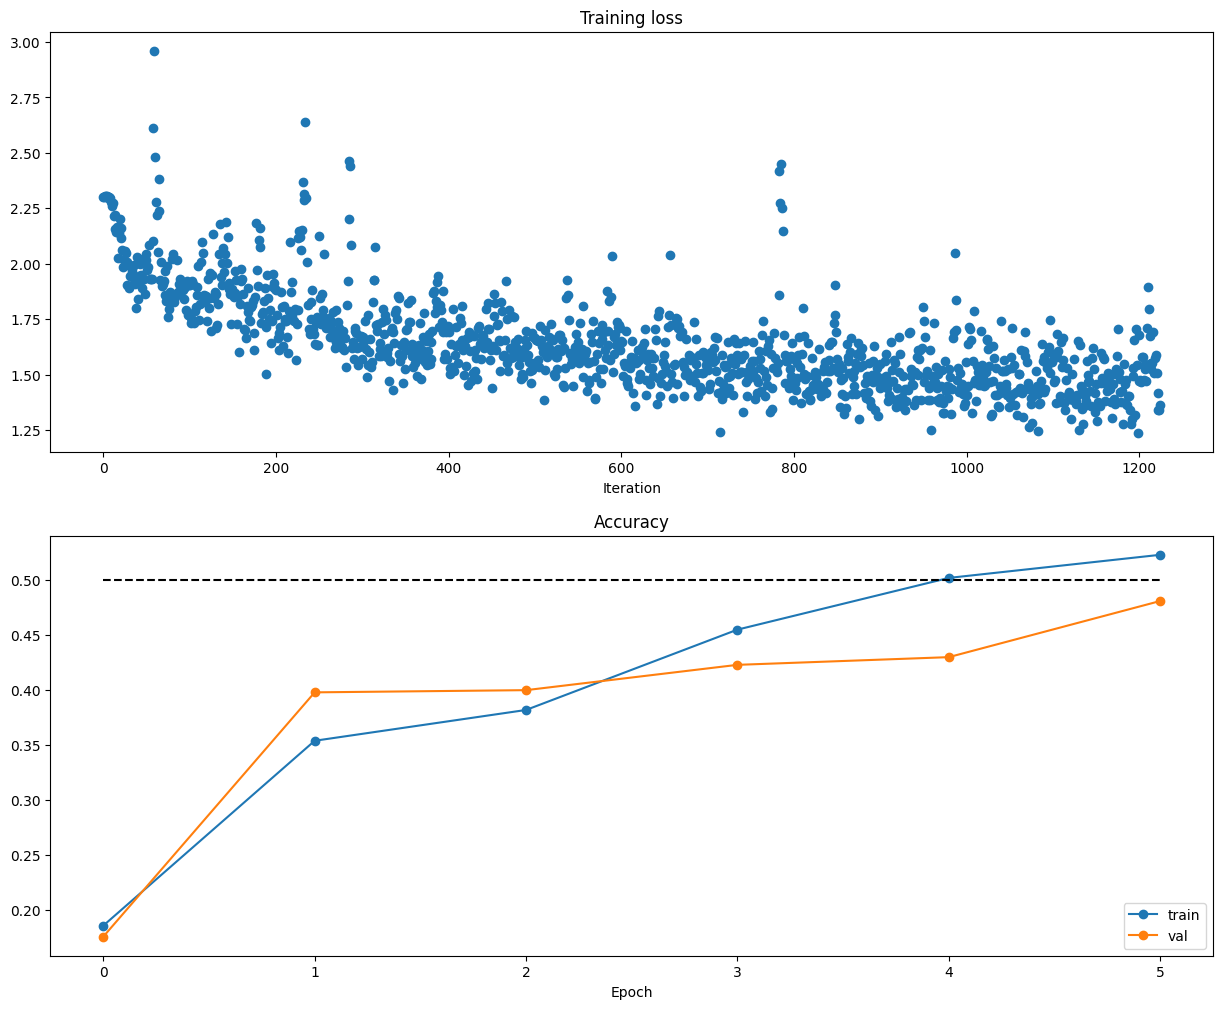

In [17]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

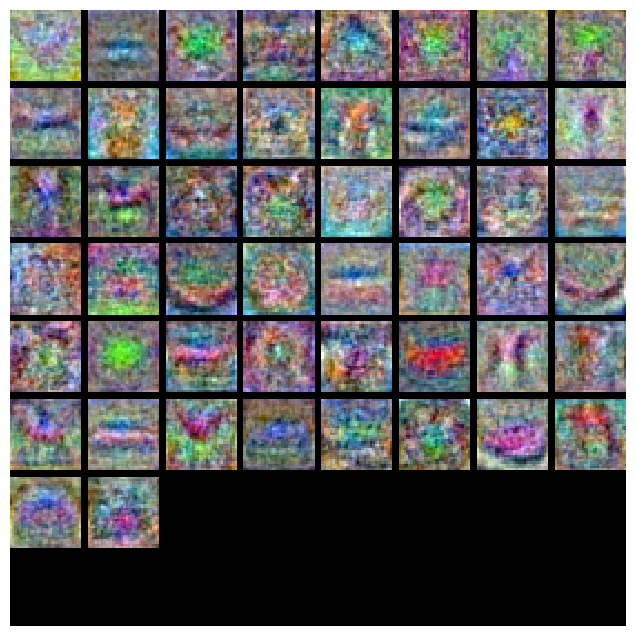

In [18]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [19]:
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None


##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(model, split_data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': 1e-4,
                },
                lr_decay=0.95,
                num_epochs=5, batch_size=200,
                print_every=100)
solver.train()


Streaming output truncated to the last 5000 lines.
   3.57358066]
 [ 1.24053899  2.07857392 -0.04730891 ... -0.32294002  1.68701282
   3.61093623]]

(200, 3072) (3072, 50) (50, 10)
[[ 5.05424942  2.69827673  0.04517895 ... -0.23946653  0.9458246
   1.4293388 ]
 [-0.25917165 -0.98028328  0.43123312 ... -0.2343043  -0.46607963
  -1.22800761]
 [ 0.61142367 -2.80896355  1.76985156 ...  1.38870428 -3.52986943
  -1.04286561]
 ...
 [-0.21423886 -1.68913703  0.55142643 ... -0.69535488 -0.99225646
  -0.54532997]
 [ 0.22862622  1.74672034 -0.40652045 ...  0.29237462 -2.44514463
  -4.01890755]
 [-1.39570285 -1.15828718 -0.13944509 ...  0.16057446 -0.96094418
   0.08120677]]

(200, 3072) (3072, 50) (50, 10)
[[ 0.17690014 -1.88431144  0.08322974 ...  1.76136775 -1.88532596
   4.73439494]
 [-0.21262806 -1.43290585  0.96935561 ...  1.40252774  0.17961912
  -1.53521071]
 [-0.82696088 -1.40363062 -0.47784934 ...  1.0043686  -1.68578834
  -1.52127567]
 ...
 [-1.70444515 -2.97373998 -0.18206938 ...  0.19

In [20]:
hidden_size

50

In [21]:
# range(1e-7)

In [22]:
# np.geomspace(3e-4, 3e-2, 1)

In [23]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# learning_rates = [1e-6, 1e-7, 1e-8]
# regularization_strengths = [0.0001, 0.001]

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 3)
#num_folds = 5
#X_train_folds=np.array_split(X_train, num_folds)
#y_train_folds=np.array_split(y_train, num_folds)
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#cv_fold=list(range(num_folds))

# Import useful libraries
import sys
import itertools

# Binary variable to print extra info within the loop
Verbose=False
#label_folds = np.array_split(y_train, 5)
results = {}
best_val = -1

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    model = TwoLayerNet(hidden_dim=256, reg=reg)
    solver = Solver(model, split_data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': lr,
                },
                lr_decay=0.1,
                num_epochs=20, batch_size=200,
                print_every=100)
    solver.train()
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Streaming output truncated to the last 5000 lines.
 [-1.60031595 -3.05656611  2.22658671 ...  4.67873936 -3.3478535
  -5.73430747]
 [ 4.26105255 -5.39680905  3.92891405 ... -0.44679038 -2.02235498
  -4.4723894 ]]

(200, 3072) (3072, 256) (256, 10)
[[-8.1413797   6.36475062 -0.14444713 ... -7.0084862   0.17868233
   8.9985309 ]
 [-1.50477302  2.23265104  3.01211051 ... -2.15759952 -2.17919999
   1.73564705]
 [ 1.76437256 19.25096852 -1.66938674 ... -8.95675622 -4.16934739
   9.06312086]
 ...
 [-8.71080353  4.01283982  2.29788693 ... -9.36635229  2.75788671
   2.02330538]
 [-1.64500656  3.9236916   2.11012773 ... -9.81563106  4.14274384
   3.0447277 ]
 [ 3.34345911 -2.32374709  2.77955735 ... -0.33210028  0.48364199
  -2.60014025]]

(200, 3072) (3072, 256) (256, 10)
[[-2.20399106  1.4248189   4.09923394 ... -5.58780496 -9.69765028
  -3.12117154]
 [-5.06795063 -7.20287665  4.23940962 ...  5.64787796  3.52623399
   1.72246014]
 [-2.72277857 -1.14551839  0.1651955  ... -0.58389087 -6.746209

/content/drive/My Drive/assignments/assignment1/cs231n/classifiers/fc_net.py:148: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(preds[np.arange(num_examples), y])) / num_examples
/content/drive/My Drive/assignments/assignment1/cs231n/classifiers/fc_net.py:139: RuntimeWarning: overflow encountered in exp
  preds = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
/content/drive/My Drive/assignments/assignment1/cs231n/classifiers/fc_net.py:139: RuntimeWarning: invalid value encountered in true_divide
  preds = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)


Streaming output truncated to the last 5000 lines.
  -7.87703949e+248 -1.56534321e+247]
 [ 4.77061962e+246 -5.64741833e+246 -2.97483770e+246 ...  3.10436077e+246
  -3.86908932e+246  3.66218278e+246]
 ...
 [ 3.07979136e+247  5.66606540e+246 -2.57449826e+247 ...  2.63629638e+247
  -6.47405286e+247 -4.20583198e+246]
 [ 1.58107530e+248  3.11437133e+246 -1.81380261e+248 ...  1.63815058e+248
  -3.19700404e+248 -8.04763571e+246]
 [ 1.93788062e+247 -2.85441185e+247 -4.90108438e+246 ...  2.87613601e+247
  -1.32069140e+247  1.18011572e+247]]

(200, 3072) (3072, 256) (256, 10)
[[-4.04731755e+246  3.70789728e+247 -5.47814267e+247 ... -3.09891337e+248
  -1.62914760e+248  1.22759906e+248]
 [ 6.77006178e+246  8.65502989e+246  9.81814422e+246 ... -2.49274810e+247
   1.37181942e+247  7.75412514e+246]
 [-1.08686326e+247  3.78267075e+247 -6.99714135e+246 ... -9.63640003e+247
  -4.95150205e+247  1.19071975e+247]
 ...
 [ 1.91941425e+246 -1.67932382e+247 -1.67751156e+246 ... -2.97136540e+247
  -1.40060715e+

/content/drive/My Drive/assignments/assignment1/cs231n/classifiers/fc_net.py:142: RuntimeWarning: overflow encountered in subtract
  shifted_scores = scores - np.max(scores, axis=1, keepdims=True)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/assignments/assignment1/cs231n/classifiers/fc_net.py:142: RuntimeWarning: invalid value encountered in subtract
  shifted_scores = scores - np.max(scores, axis=1, keepdims=True)


Streaming output truncated to the last 5000 lines.
 [ 0.50522059  2.13223188 -1.20205112 ...  0.35912533  1.33696348
  -1.53217003]
 ...
 [ 1.68680584 -2.79198495  0.06812936 ...  1.11802498  0.03204115
  -1.07637309]
 [ 0.41270678  0.30358155  0.43089701 ... -0.96791775  0.33815814
  -0.190594  ]
 [ 1.17588368  0.20027222  0.04404615 ...  0.38633377  1.37337667
   0.02757638]]

(200, 3072) (3072, 256) (256, 10)
[[ 1.56813117 -1.34309956  0.98574085 ... -0.69400159  1.84562253
  -0.03638083]
 [ 0.05898944  0.64560171 -0.26929052 ...  0.64682339 -1.60826851
   2.08873012]
 [-1.27530986 -1.70385626  1.59202291 ...  1.03157054 -2.09612791
  -0.32411928]
 ...
 [-0.82235174 -1.4526822  -0.40788328 ...  2.10343088 -0.24339246
  -0.82358809]
 [-0.42679876 -0.61857029 -0.09895748 ... -0.27670738 -0.59779936
   0.55199632]
 [ 4.46244098  1.72039819 -1.84880055 ... -3.44226158  9.59410714
   1.86309806]]

(200, 3072) (3072, 256) (256, 10)
[[ 0.14857515 -1.15961164 -0.99481354 ...  1.2050854  -0.

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [31]:
best_model.loss(data['X_val'])

(1000, 3072) (3072, 256) (256, 10)


array([[ 2510.47771348,  2810.60832636,  -371.21223231, ...,
        -1706.48695894,  3218.08268217,  2576.45318196],
       [ 1488.75125325, -3234.66980499,   629.70326648, ...,
         -675.926534  , -3369.84151942,  2947.1247255 ],
       [ 1473.22474851,  1634.38637202,   237.71770267, ...,
         -124.65185285,  -943.41466625,   927.776528  ],
       ...,
       [ 3341.9102995 ,  2868.61171893, -1000.54466002, ...,
         -282.77834507,  1455.38056251,  8256.94972248],
       [ 2251.57357491,  6187.24916181, -1776.03288878, ...,
          239.81997291,  2932.88040434,  5237.29125464],
       [  994.69315748,  1572.14694344,   314.7786342 , ...,
         -296.91443446,   862.81152001,  2281.32732099]])

In [24]:
y_val_pred = np.argmax(best_model.loss(split_data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == split_data['y_val']).mean())

(1000, 3072) (3072, 256) (256, 10)
Validation set accuracy:  0.529


In [25]:
y_test_pred = np.argmax(best_model.loss(split_data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == split_data['y_test']).mean())

(1000, 3072) (3072, 256) (256, 10)
Test set accuracy:  0.514


In [27]:
import pickle

In [28]:
# with open('model_save.pkl', "wb") as f:
#     pickle.dump(best_model.params, f)


In [95]:
n_data = {}
for k, v in split_data.items():
  n_data[k] = v

In [35]:
list(split_data.keys())

['y_train', 'X_val', 'y_val', 'X_test', 'y_test']

In [42]:
split_data['X_train'].reshape(X_train.shape[0], -1).shape

(49000, 3072)

In [43]:
# Model has been saved to model_save.pkl file
# We can now use or try PCA and check what we get..

# Start PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = split_data['X_train'].reshape(X_train.shape[0], -1)
X_val = split_data['X_val'].reshape(X_val.shape[0], -1)
X_test = split_data['X_test'].reshape(X_test.shape[0], -1)

X_tr_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Perform PCA
pca = PCA()
pca.fit(X_tr_scaled)

explained_variances = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_variances = np.cumsum(explained_variances)
print("Explained variances : {} \t Cumulative variances : {}".format(explained_variances, cumulative_variances))
# Set the desired threshold for cumulative explained variance
desired_variance_threshold = 0.9

# Find the number of components that surpass the threshold
num_components = np.argmax(cumulative_variances >= desired_variance_threshold) + 1

print("Number of components to retain:", num_components)


Explained variances : [2.69162908e-01 1.13786675e-01 7.15810141e-02 ... 7.86436216e-09
 7.32604147e-09 7.29711707e-09] 	 Cumulative variances : [0.26916291 0.38294958 0.4545306  ... 0.99999999 0.99999999 1.        ]
Number of components to retain: 103


In [44]:
pca = PCA(n_components=num_components)  # Set the desired number of components
X_train_pca = pca.fit_transform(X_tr_scaled)

# Apply the same PCA transformation to the test data
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)


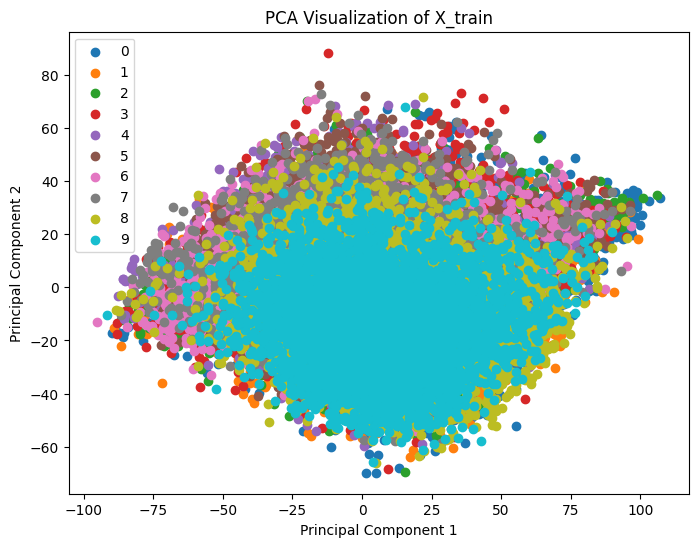

In [59]:
y_train = split_data['y_train']
# y_val = split_data['y_train']
# y_train = split_data['y_train']
labels = np.unique(y_train)

# Create a scatter plot
plt.figure(figsize=(8, 6))
for label in labels:
    plt.scatter(
        X_train_pca[y_train == label, 0],
        X_train_pca[y_train == label, 1],
        label=str(label)
    )
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization of X_train')
plt.legend()
plt.show()

In [50]:
X_tr_scaled[:50].shape

(50, 3072)

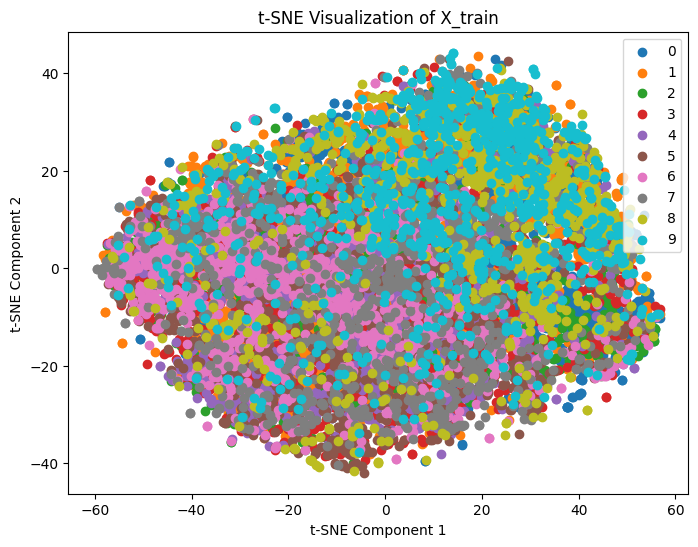

In [66]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)  # Set the desired number of components for visualization
X_train_tsne = tsne.fit_transform(X_tr_scaled[:10000])

plt.figure(figsize=(8, 6))
for label in labels:
    plt.scatter(
        X_train_tsne[y_train[:10000] == label, 0],
        X_train_tsne[y_train[:10000] == label, 1],
        label=str(label)
    )
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of X_train')
plt.legend()
plt.show()

In [89]:
x_md = data['X_train']

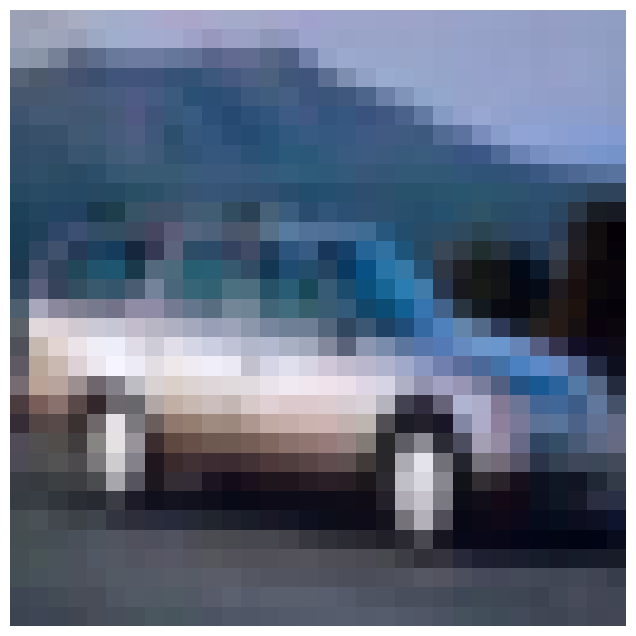

10 car


In [93]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
x_new = x_md[y_train == 1][0].reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
plt.imshow(visualize_grid(x_new, padding=3).astype('uint8'))
plt.gca().axis('off')
plt.show()

print(len(classes), classes[1])

In [97]:
n_data['X_train'] = X_train_pca
n_data['X_test'] = X_test_pca
n_data['X_val'] = X_val_pca
# Apply the same PCA transformation to the test data
# X_test_pca = pca.transform(X_test_scaled)
# X_val_pca = pca.transform(X_val_scaled)


In [99]:
X_train_pca.shape

(49000, 103)

In [108]:
best_model = None


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                          #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# learning_rates = [1e-6, 1e-7, 1e-8]
# regularization_strengths = [0.0001, 0.001]

learning_rates = np.geomspace(3e-4, 3e-2, 3)
regularization_strengths = np.geomspace(1e-6, 1e-2, 3)
#num_folds = 5
#X_train_folds=np.array_split(X_train, num_folds)
#y_train_folds=np.array_split(y_train, num_folds)
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
#cv_fold=list(range(num_folds))

# Import useful libraries
import sys
import itertools

# Binary variable to print extra info within the loop
Verbose=False
#label_folds = np.array_split(y_train, 5)
results = {}
best_val = -1

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    model = TwoLayerNet(hidden_dim=128, reg=reg, input_dim=103)
    solver = Solver(model, n_data,
                update_rule='sgd',
                optim_config={
                  'learning_rate': lr,
                },
                lr_decay=0.1,
                num_epochs=20, batch_size=200,
                print_every=100)
    solver.train()
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_model = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Streaming output truncated to the last 5000 lines.
(100, 103) (103, 128) (128, 10)
Called here!
(100, 103) (103, 128) (128, 10)
(Epoch 18 / 20) train acc: 0.096000; val_acc: 0.087000
Called here!
(200, 103) (103, 128) (128, 10)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

Called here!
(200, 103) (103, 128) (128, 10)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

Called here!
(200, 103) (103, 128) (128, 10)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]

Called here!
(200, 103) (103, 128) (128, 10)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan n

In [105]:
#lr 3.000000e-04 reg 1.000000e-06 val accuracy: 0.525000
model = TwoLayerNet(hidden_dim=256, reg=1e-06, input_dim=103)
solver = Solver(best_model, n_data,
            update_rule='sgd',
            optim_config={
              'learning_rate': 3e-4,
            },
            lr_decay=0.1,
            num_epochs=20, batch_size=200,
            print_every=100)
solver.train()

103 256
Called here!
(200, 103) (3072, 256) (256, 10)


ValueError: ignored

## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$

$\color{blue}{\textit Your Explanation:}$

